In [1]:
! pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 99.0 MB/s eta 0:00:00


In [2]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

/ext3/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# Step 1: Load processed dataset
processed_file_path = "/scratch/gl2758/PTSA/output/MSG_30min_raw_train.csv"  # Update with your file path
data = pd.read_csv(processed_file_path)

In [4]:
data.head()

,tpep_pickup_datetime,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday
0,2022-01-24 00:00:00,13.0,49.14,1583,173.00,237.35,1.615,12,0,2022-01-24 00:00:00,0
1,2022-01-24 00:30:00,9.0,51.99,1524,174.43,245.92,2.770,9,0,2022-01-24 00:30:00,0
2,2022-01-24 01:00:00,12.0,37.72,1242,137.50,209.51,2.110,12,0,2022-01-24 01:00:00,0
3,2022-01-24 01:30:00,7.0,11.99,785,50.50,86.39,2.010,6,0,2022-01-24 01:30:00,0
4,2022-01-24 02:00:00,7.0,15.40,998,64.50,94.95,0.000,6,0,2022-01-24 02:00:00,0


In [5]:
# Step 2: Prepare the dataset for Prophet
# Ensure the datetime column is properly parsed
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
# Rename columns to match Prophet requirements
prophet_data = data.rename(columns={"tpep_pickup_datetime": "ds", "pickup_count": "y"})

In [6]:
# Step 3: Initialize the Prophet model
model = Prophet(interval_width=0.95)  # 95% confidence interval

# Step 4: Fit the model
model.fit(prophet_data)

00:51:29 - cmdstanpy - INFO - Chain [1] start processing
00:51:30 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Step 5: Create a DataFrame for future predictions
future = model.make_future_dataframe(periods=48, freq='30min')  # Predict the next 24 hours (48 x 30min intervals)

# Step 6: Make predictions
forecast = model.predict(future)

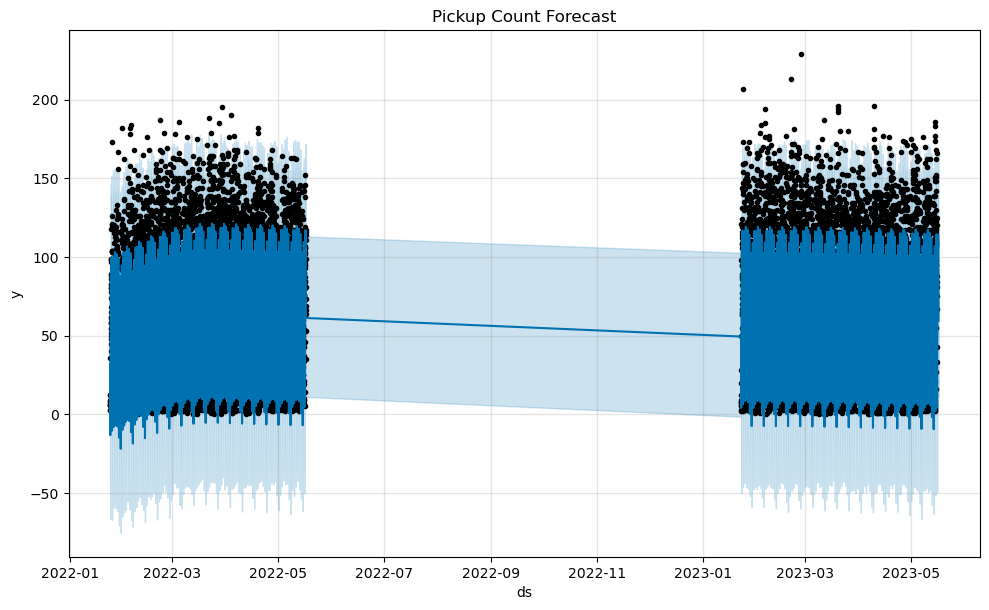

In [8]:
# Step 7: Visualize the forecast
fig = model.plot(forecast)
plt.title("Pickup Count Forecast")
plt.show()

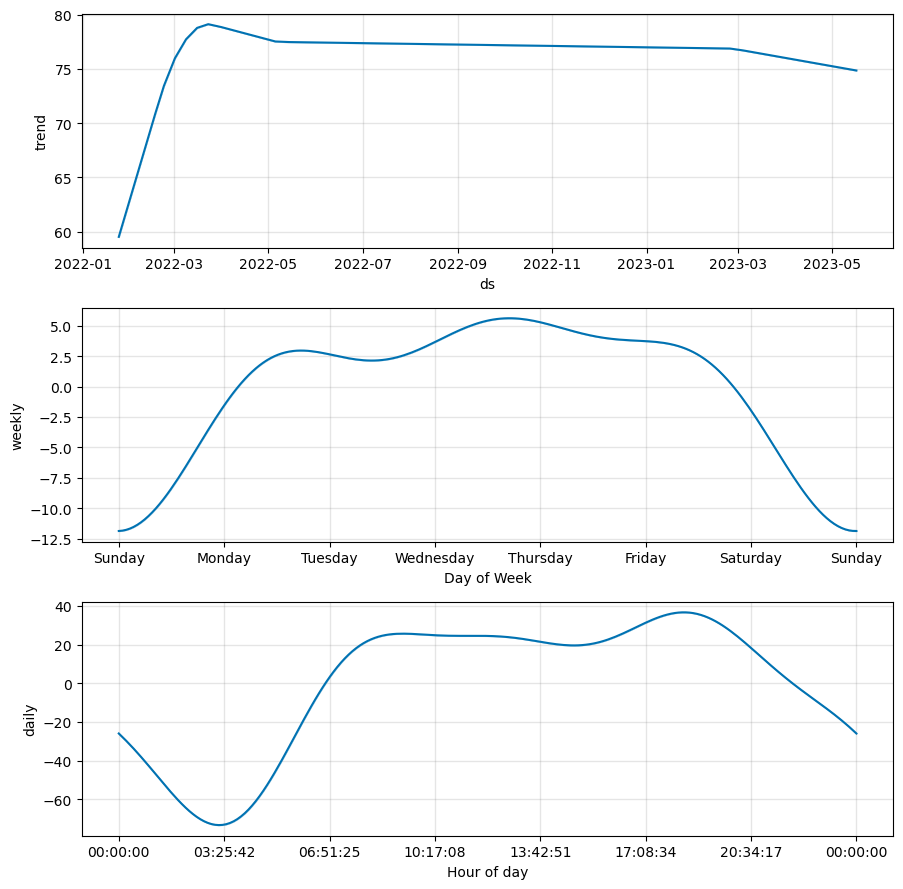

In [9]:
# Step 8: Visualize forecast components
fig_components = model.plot_components(forecast)
plt.show()

In [10]:
# Save the forecast to a CSV file (optional)
output_path = "/scratch/gl2758/PTSA/output/prophet_MSG_30min_forecast.csv"
forecast.to_csv(output_path, index=False)

print(f"Forecast saved to {output_path}")

Forecast saved to /scratch/gl2758/PTSA/output/prophet_MSG_30min_forecast.csv


---

In [11]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Load the processed train and test datasets
train_path = "/scratch/gl2758/PTSA/output/MSG_30min_raw_train.csv"  # Replace with actual path
test_path = "/scratch/gl2758/PTSA/output/MSG_30min_raw_test.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Prepare the datasets
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Rename columns for Prophet
train = train.rename(columns={"tpep_pickup_datetime": "ds", "pickup_count": "y"})
test = test.rename(columns={"tpep_pickup_datetime": "ds", "pickup_count": "y"})

# Add additional features
train['hour'] = train['ds'].dt.hour
train['weekday'] = train['ds'].dt.weekday
train['weekend'] = (train['weekday'] >= 5).astype(int)
test['hour'] = test['ds'].dt.hour
test['weekday'] = test['ds'].dt.weekday
test['weekend'] = (test['weekday'] >= 5).astype(int)

In [13]:
# Initialize the Prophet model with additional seasonalities
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.95,
    seasonality_mode="multiplicative"
)

# Add seasonalities
model.add_seasonality(name="hourly", period=24, fourier_order=6)
model.add_seasonality(name="daily", period=7, fourier_order=6)

# Add regressors
model.add_regressor("hour")
model.add_regressor("weekday")
model.add_regressor("weekend")

# Fit the model
model.fit(train)

01:39:14 - cmdstanpy - INFO - Chain [1] start processing
01:39:16 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Prepare the test dataset for predictions
future = test[['ds', 'hour', 'weekday', 'weekend']]

# Make predictions
forecast = model.predict(future)

# Evaluation metrics
y_true = test['y'].values
y_pred = forecast['yhat'].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Prophet Model RMSE: {rmse:.3f}")
print(f"Prophet Model R²: {r2:.3f}")

Prophet Model RMSE: 38.569
Prophet Model R²: 0.287


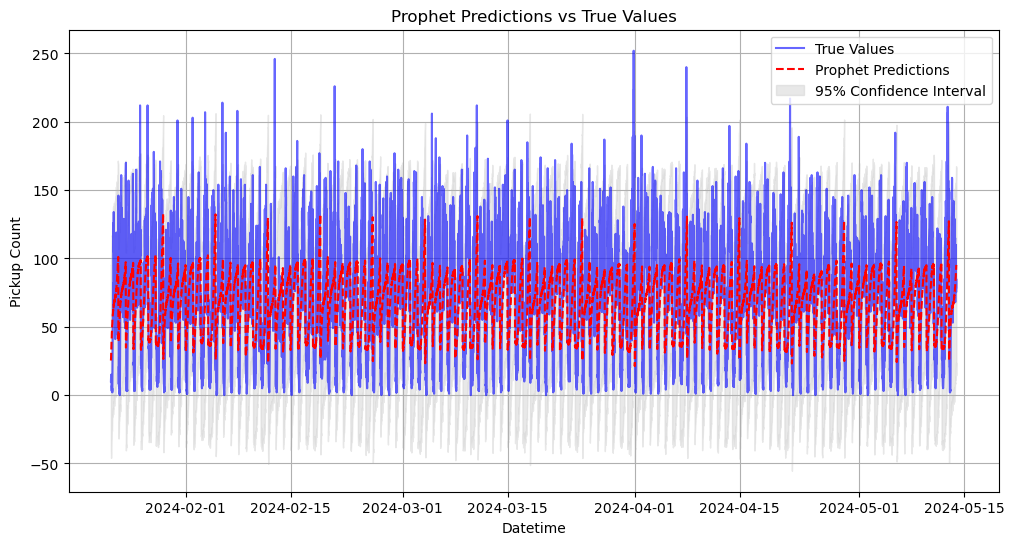

In [ ]:
# Visualization of predictions
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], y_true, label="True Values", color="blue", alpha=0.6)
plt.plot(test['ds'], y_pred, label="Prophet Predictions", color="red", linestyle="dashed")
plt.fill_between(
    test['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval"
)
plt.xlabel("Datetime")
plt.ylabel("Pickup Count")
plt.title("Prophet Predictions vs True Values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Residual analysis
residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid()
plt.show()